In [1]:
%matplotlib inline
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('white')
sns.set_context('notebook')

Read in a set of CCFs

In [2]:
from glob import glob
from astropy.io import fits as pf
def read_ccfs(prefix, root = '../data/SOAP2'):
    fls = np.sort(glob('{:s}/{:s}/CCF*.fits'.format(root, prefix)))
    nobs = len(fls)
    hdul = pf.open(fls[0])
    hdr = hdul[0].header
    nvel = int(hdr['NAXIS1'])
    vel = np.arange(nvel) * float(hdr['STEP']) 
    vel -= max(vel)/2.
    ccf = np.zeros((nobs,nvel))
    for i in range(nobs):
        hdul = pf.open(fls[i])
        ccf[i,:] = hdul[0].data.flatten()
        hdul.close()
    return vel, ccf

In [3]:
vel, ccfs = read_ccfs('spot_only')
nobs,nvel=ccfs.shape
sig=1e-5
ccfs += np.random.normal(0,sig,ccfs.shape)

In [4]:
ccf_ref = ccfs.mean(axis=0)
ccf_res = ccfs-ccf_ref[None,:]

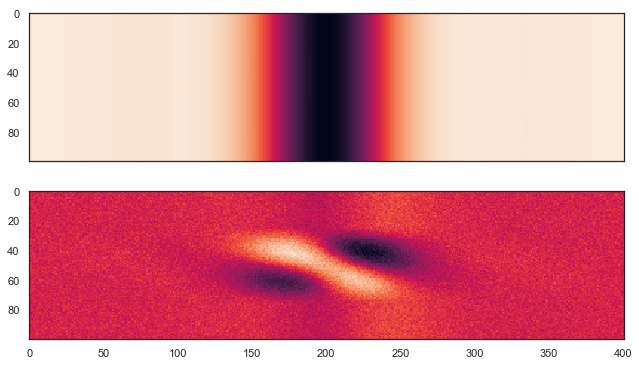

In [5]:
fig,axes = plt.subplots(2,1,figsize=(12,6),sharex=True, sharey=True)
axes[0].imshow(ccfs)
axes[1].imshow(ccf_res)

define routines for fitting single CCF

In [91]:
from george import kernels, GP
from scipy.optimize import minimize
from scipy.interpolate import interp1d
def Gauss(p,x):
    amp, x0, sigma = p
    m = 1.0 - amp * np.exp(-(x-x0)**2/2/sigma**2)
    return m
def nll_Gauss(p,x,y):
    m = Gauss(p,x)
    r = y - m
    return (r**2).sum()
def nll_GP_plus_Gauss(p,x,y,gp):
    pGauss = p[:3]
    pGP = p[3:]
    m = Gauss(pGauss,x)
    r = y - m
    gp.set_parameter_vector(pGP)
    try:
        gp.compute(x)
    except:
        return 1e25
    return -gp.log_likelihood(y)
def nll_shift_interp(p,x,y,interp1d_fun):
    # ultimately should replace this with proper GP interpolation
    m = interp1d_fun(x+p[0])
    r = y - m
    return (r[1:-1]**2).sum()

In [92]:
pGauss_init = np.array([0.55,0.0,3.0])
soln = minimize(nll_Gauss, pGauss_init, args=(vel,ccf_ref))
pGauss_init = soln.x
print(pGauss_init)

[ 0.52817456 -0.04742079  2.96142546]


[  0.52817456  -0.04742079   2.96142546 -19.99071474  -0.19746313
   2.05899536]


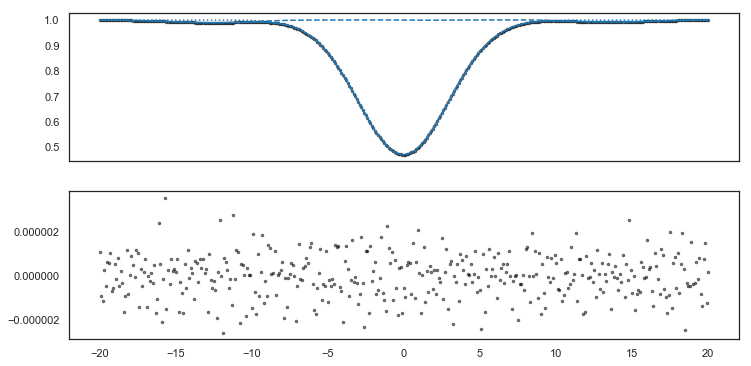

In [93]:
k = 1.0 * kernels.ExpSquaredKernel(1.0)
gp = GP(k,mean=0.0, white_noise=np.log(sig/np.sqrt(nobs)),fit_mean=False,fit_white_noise=True)
pGP_init = gp.get_parameter_vector()
p_init = np.concatenate([pGauss_init,pGP_init])
soln = minimize(nll_GP_plus_Gauss, p_init, args=(vel,ccf_ref,gp))
p_fit = soln.x
pGauss_fit = p_fit[:3]
m = Gauss(pGauss_fit,vel)
pGP_fit = p_fit[3:]
gp.set_parameter_vector(pGP_fit)
gp.compute(vel)
r = ccf_ref - m
mu = gp.predict(r,vel,return_var=False, return_cov=False)
fig,axes = plt.subplots(2,1,sharex=True,figsize=(12,6))
axes[0].plot(vel,ccf_ref,'k.',ms=5,alpha=0.5)
axes[0].plot(vel,mu+m,'C0')
axes[0].plot(vel,m,'C0:')
axes[0].plot(vel,1+mu,'C0--')
axes[1].plot(vel,ccf_ref-m-mu,'k.',ms=5,alpha=0.5)
print(p_fit)

In [94]:
v_single = np.zeros(nobs)
yref = m + mu
shift_res = np.zeros_like(ccfs)
p_init = np.array([0.0])
intfun = interp1d(vel,yref,bounds_error=False)
for i in range(nobs):
    soln = minimize(nll_shift_interp, [0.0], args=(vel,ccfs[i,:].flatten(),intfun))
    v_fit = soln.x[0]
    m = intfun(vel+v_fit)
    r = ccfs[i,:].flatten() - m
    shift_res[i,:] = r
    v_single[i] = v_fit
    print(i,v_fit)

0 0.00010528061171348581
1 0.00010411237581832903
2 0.0001147479344868863
3 0.00010919386375877589
4 0.0001272740061200896
5 0.0001107782862722278
6 0.00012058164529542929
7 0.00012634505724053882
8 0.00014055893257548596
9 0.00012058777439127256
10 0.00012322119370166822
11 0.00012403733177915137
12 0.00011932604174619168
13 0.00011741160218915528
14 0.00011487873348206443
15 0.0001065919239235572
16 0.00010159626152930226
17 9.411424895084892e-05
18 0.00013713226353434402
19 0.00011129574463193017
20 0.00012494553708655275
21 0.00011460711761568501
22 0.00011103037973009833
23 9.500867657904554e-05
24 0.00011468908300150224
25 7.244556914736341e-05
26 3.536871039029485e-05
27 -2.6444220767566967e-05
28 -0.00013095642846137505
29 -0.00024520848400426284
30 -0.0003811182685075487
31 -0.0004899539256137791
32 -0.000617873280990043
33 -0.0007717851134248714
34 -0.0008190627239941824
35 -0.0009841842513080442
36 -0.001062483983979155
37 -0.001142834086567792
38 -0.0012236676061364382
39 -

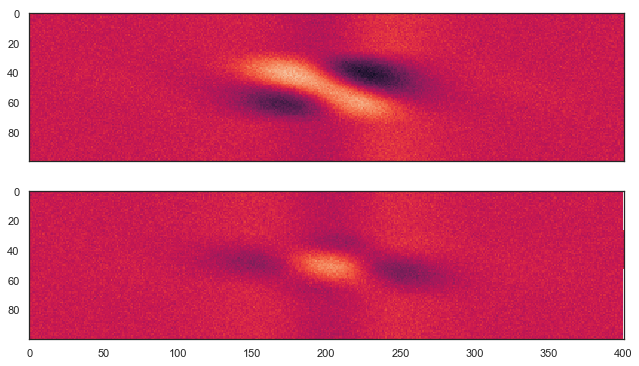

In [95]:
fig,axes = plt.subplots(2,1,figsize=(12,6),sharex=True, sharey=True)
vmax = 1.1 * abs(noshift_res).max()
axes[0].imshow(ccf_res,vmin=-vmax,vmax=vmax)
axes[1].imshow(shift_res,vmin=-vmax,vmax=vmax)

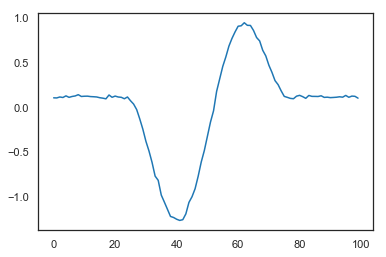

In [97]:
plt.plot(v_single*1e3)

In [ ]:
def neg_ln_like(p,gp):
    gp.set_parameter_vector(p)
    return -gp.log_likelihood(y)
def grad_neg_ln_like(p,gp):
    gp.set_parameter_vector(p)
    return -gp.grad_log_likelihood(y)
y = ccf0
result = minimize(neg_ln_like, gp0.get_parameter_vector(), jac=grad_neg_ln_like, args=(gp0))
hp0 = result.x
gp0.set_parameter_vector(hp0)
print(gp0.get_parameter_names())
print(hp0)
plt.plot(vel,ccf0,'k.',ms=5,alpha=0.5)
mu = gp0.predict(ccf0,vel,return_cov=False,return_var=False)
plt.plot(vel,mu)

In [ ]:
ccf_res = ccfs - mu[None,:]
plt.imshow(ccf_res)
plt.colorbar()

now model residuas with a separate GP

In [ ]:
k1 = np.exp(hp0[-2]) * kernels.ExpSquaredKernel(np.exp(hp0[-1]))
gp1 = GP(k1, mean = 0., white_noise = np.log(sig), fit_mean=False,fit_white_noise=True)
gp1.compute(vel)
y = ccf_res[50,:].flatten()
result = minimize(neg_ln_like, gp1.get_parameter_vector(), jac=grad_neg_ln_like, args=(gp1))
hp1 = result.x
gp1.set_parameter_vector(hp1)
print(hp1)
plt.plot(vel,y,ms=5,alpha=0.5)
mu = gp1.predict(y,vel,return_cov=False,return_var=False)
plt.plot(vel,mu)

In [ ]:
y = ccf_res[50,:].flatten()
result = minimize(neg_ln_like, gp.get_parameter_vector(), jac=grad_neg_ln_like)
hp0 = result.x

residuals from each observation with a GP (to get GP HPs)

In [ ]:
from george import kernels, GP
from scipy.optimize import minimize
k = 1.0 * kernels.ExpSquaredKernel(1.0)
gp = GP(k)
gp.compute(vel)
def neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.log_likelihood(y)
def grad_neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.grad_log_likelihood(y)
y = ccf_res[50,:].flatten()
result = minimize(neg_ln_like, gp.get_parameter_vector(), jac=grad_neg_ln_like)
hp0 = result.x


In [ ]:
nobs,nvel = ccf_res.shape
HPs = np.zeros((nobs,len(hp0))) + np.nan
for i in range(nobs):
    y = ccf_res[i,:].flatten()
    if abs(y).max() < 1e-8:
        continue
    result = minimize(neg_ln_like, hp0, jac=grad_neg_ln_like)
    HPs[i,:] = result.x
    print(result.x)
HPs = np.nanmedian(HPs,axis=0)
print(HPs)


In [ ]:
gp.set_parameter_vector(HPs)

k2 = 1.0 * kernels.ExpSquaredKernel(1.0)
gp2 = gp
y = ccf0

gp2 = gp(k+k2)
def nll

fig,axes=plt.subplots(1,4,sharex=True,figsize = (16,4))
axes[0].plot(x1,'k-')
axes[0].plot(x2-1,'k--')
axes[0].plot(x3-2,'k:')
axes[0].plot(x4-3,'k-.')
ii = 0
offset = 0.0001
p1 = []
p2 = []
p3 = []
for i in range(len(fl1)):
    hdul = pf.open(fl1[i])
    d = hdul[0].data.flatten()
    dr = d - d0
    #if max(abs(dr)) <= 1e-6: 
    #1    continue
    dmin, dmax = dr.min(), dr.max()
    y1 = (dr - dmin) / (dmax - dmin)
    y1 = dr[:]
    hdul.close()
    hdul = pf.open(fl2[i])
    d = hdul[0].data.flatten()
    dr = d - d0
    dmin, dmax = dr.min(), dr.max()
    y2 = (dr - dmin) / (dmax - dmin)
    y2 = dr[:]
    hdul.close()
    hdul = pf.open(fl3[i])
    d = hdul[0].data.flatten()
    dr = d - d0
    dmin, dmax = dr.min(), dr.max()
    y3 = (dr - dmin) / (dmax - dmin)
    y3 = dr[:]
    hdul.close()
    def model(p):
        m = p[0] + p[1] * x1 + p[2] * x2 + p[3] * x3 + p[4] * x4
        return m
    def nll(p,y):
        m = model(p)
        return ((y-m)**2).sum()
    p0 = np.zeros(5)
    soln = minimize(nll,p0,args=(y1))
    p1.append(soln.x)
    m1 = model(soln.x)
    soln = minimize(nll,p0,args=(y2))
    p2.append(soln.x)
    m2 = model(soln.x)
    soln = minimize(nll,p0,args=(y3))
    p3.append(soln.x)
    m3 = model(soln.x)
    axes[1].plot(y1-offset*ii,'k-',lw=0.5,alpha=1)
#    axes[1].plot(m1-offset*ii,'r--',lw=0.5,alpha=0.5)
    axes[2].plot(y2-offset*ii,'k-',lw=0.5,alpha=1)
#    axes[2].plot(m2-offset*ii,'r--',lw=0.5,alpha=0.5)
    axes[3].plot(y3-offset*ii,'k-',lw=0.5,alpha=1)
#    axes[3].plot(m3-offset*ii,'r--',lw=0.5,alpha=0.5)
    ii += 1
print(ii)
axes[0].xaxis.set_visible(False) 
axes[0].yaxis.set_visible(False) 
axes[1].xaxis.set_visible(False) 
axes[1].yaxis.set_visible(False) 
axes[2].xaxis.set_visible(False) 
axes[2].yaxis.set_visible(False) 
axes[3].xaxis.set_visible(False) 
axes[3].yaxis.set_visible(False) 
axes[0].set_title('CCF and derivatives')
axes[1].set_title('spot only')
axes[2].set_title('plage only')
axes[3].set_title('spot and plage')
plt.savefig('diff_ccf.png')

In [ ]:
x = np.arange(len(d0))*0.1 
x -= x.max()/2
vs = 0.001 * ((np.arange(100)-50))
offset=0.01
p4 = []
for ii, v in enumerate(vs):
    xs = x+v
    g = interp1d(xs,d0, bounds_error=False,fill_value=1.0)
    d = g(x)
    dr = d-d0
    dmin, dmax = dr.min(), dr.max()
    if dmin < dmax:
        y = (dr - dmin) / (dmax - dmin)
    else:
        y = dr + .5
    y = dr[:]
    def model(p):
        m = p[0] + p[1] * x1 + p[2] * x2 + p[3] * x3 + p[4] * x4
        return m
    def nll(p,y):
        m = model(p)
        return ((y-m)**2).sum()
    p0 = np.zeros(5)
    soln = minimize(nll,p0,args=(y))
    m = model(soln.x)
    p4.append(soln.x)
    plt.plot(y-offset*ii,'k-',lw=0.5)
#    plt.plot(m-offset*ii,'r--')
    


In [ ]:
p1 = np.array(p1).T
p2 = np.array(p2).T
p3 = np.array(p3).T
p4 = np.array(p4).T

In [ ]:
fig,axes=plt.subplots(1,1,figsize = (10,8))
axes.plot(p4[2],p4[0],'C0.',ms=5,alpha=0.5,label='constant')
axes.plot(p4[2],p4[1],'C1.',ms=5,alpha=0.5,label='CCF')
axes.plot(p4[2],p4[3],'C2.',ms=5,alpha=0.5,label='2nd deriv')
axes.plot(p4[2],p4[4],'C3.',ms=5,alpha=0.5, label='3rd deriv')
plt.legend()

In [ ]:
#axes[1].scatter(p1[2],p1[3],s=5,c=vs,edgecolor='none')
#axes[2].scatter(p2[2],p2[3],s=5,c=vs,edgecolor='none')
#axes[3].scatter(p3[2],p3[3],s=5,c=vs,edgecolor='none')
#axes[1].yaxis.set_visible(False) 
axes[0].set_title('doppler only')
axes[1].set_title('spot only')
axes[2].set_title('plage only')
axes[3].set_title('spot and plage')
axes[0].set_ylabel('first deriv')
axes[0].set_xlabel('constant')
axes[1].set_xlabel('constant')
axes[2].set_xlabel('constant')
axes[3].set_xlabel('constant')

In [ ]:
def fit_gauss(x,y):
    mu0 = x[np.argmin(y)]
    c0 = max(y)-min(y)
    l = np.where(y < (max(y)-c0/2))[0]
    sig0 = 0.5*(x[l[-1]]-x[l[0]])
    def gauss(p):
        mu,c,sig = p
        return 1 - c * np.exp(-(x-mu)**2/2/sig**2)
    def nllg(p):
        m = gauss(p)
        return ((y-m)**2).sum()
    p0 = np.array([mu0,c0,sig0])
    soln = minimize(nllg,p0)
    m = gauss(soln.x)
    return soln.x,m

hdul = pf.open(fl1[0])
d0 = hdul[0].data
hdr = hdul[0].header
vels = np.arange(int(hdr['NAXIS1'])) * float(hdr['STEP']) 
vels -= max(vels)/2.
par,fit = fit_gauss(vels,d0)
plt.plot(vels,d0,'.')
plt.plot(vels,fit)
print(hdr['RV'])

In [ ]:
rv_soap_1 = np.zeros(len(fl1))
rv_1 = np.zeros(len(fl1))
rv_1_corr = np.zeros(len(fl1))
rv_soap_2 = np.zeros(len(fl1))
rv_2 = np.zeros(len(fl1))
rv_2_corr = np.zeros(len(fl1))
rv_soap_3 = np.zeros(len(fl1))
rv_3 = np.zeros(len(fl1))
rv_3_corr = np.zeros(len(fl1))
p_1 = np.zeros((3,len(fl1)))
p_2 = np.zeros((3,len(fl1)))
p_3 = np.zeros((3,len(fl1)))

hdul = pf.open(fl1[0])
d0 = hdul[0].data
dmin, dmax = d0.min(),d0.max()
x1 = (d0 - dmin) / (dmax - dmin)
d0p = np.append(d0[1:]-d0[:-1],0)
dmin,dmax = d0p.min(),d0p.max()
x2 = (d0p-dmin)/(dmax-dmin)
d0pp = np.append(0,d0p[1:]-d0p[:-1])
dmin,dmax = d0pp.min(),d0pp.max()
x3 = (d0pp-dmin)/(dmax-dmin)
hdul.close()
for i in range(len(fl1)):
    # read RV from header
    hdul = pf.open(fl1[i])
    hdr = hdul[0].header
    rv_soap_1[i] = float(hdr['RV'])
    d1 = hdul[0].data.flatten()
    hdul.close()
    hdul = pf.open(fl2[i])
    hdr = hdul[0].header
    rv_soap_2[i] = float(hdr['RV'])
    d2 = hdul[0].data.flatten()
    hdul.close()
    hdul = pf.open(fl3[i])
    hdr = hdul[0].header
    rv_soap_3[i] = float(hdr['RV'])
    d3 = hdul[0].data.flatten()
    hdul.close()
    # compute my own - should be the same up to a constant factor
    par1,_ = fit_gauss(vels,d1)
    rv_1[i] = par1[0]
    par2,_ = fit_gauss(vels,d2)
    rv_2[i] = par2[0]
    par3,_ = fit_gauss(vels,d3)
    rv_3[i] = par3[0]
    # model CCF
    d1r = d1 - d0
    if max(abs(d1r)) <= 1e-10: # no perturbation - don't fit
        rv_1_corr[i] = rv_1[i]
        rv_2_corr[i] = rv_2[i]
        rv_3_corr[i] = rv_3[i]
        continue
    d1min, d1max = d1r.min(), d1r.max()
    y1 = (d1r - d1min) / (d1max - d1min)
    d2r = d2 - d0
    d2min, d2max = d2r.min(), d2r.max()
    y2 = (d2r - d2min) / (d2max - d2min)
    d3r = d3 - d0
    d3min, d3max = d3r.min(), d3r.max()
    y3 = (d3r - d3min) / (d3max - d3min)
    def model(p):
        m = p[0] + p[1] * x1 + p[2] * x2 + p[3] * x3 
        return m
    def nllm(p,y):
        m = model(p)
        return ((y-m)**2).sum()
    p0 = np.zeros(4)
    soln = minimize(nllm,p0,args=(y1))
    p_1[:,i] = soln.x[1:]
    m1 = model(soln.x)
    soln = minimize(nllm,p0,args=(y2))
    p_2[:,i] = soln.x[1:]
    m2 = model(soln.x)
    soln = minimize(nllm,p0,args=(y3))
    p_3[:,i] = soln.x[1:]
    m3 = model(soln.x)
    # measure RV from corrected CCF
    y1c = y1 - m1
    d1c = y1c * (d1max - d1min) + d1min + d0
    par1c,_ = fit_gauss(vels,d1c)
    rv_1_corr[i] = par1c[0]
    y2c = y2 - m2
    d2c = y2c * (d2max - d2min) + d2min + d0
    par2c,_ = fit_gauss(vels,d2c)
    rv_2_corr[i] = par2c[0]
    y3c = y3 - m3
    d3c = y3c * (d3max - d3min) + d3min + d0
    par3c,_ = fit_gauss(vels,d3c)
    rv_3_corr[i] = par3c[0]
#    print(rv_1_corr[i])
rv_1 -= rv_1[0]
rv_1_corr -= rv_1_corr[0]
rv_2 -= rv_2[0]
rv_2_corr -= rv_2_corr[0]
rv_3 -= rv_3[0]
rv_3_corr -= rv_3_corr[0]
fig,axes=plt.subplots(1,2,sharex=True,figsize = (8,4))
axes[0].plot(x,rv_soap_1*1000,'C0-',label='spot only')
axes[0].plot(x,rv_soap_2*1000,'C1-',label='plage only')
axes[0].plot(x,rv_soap_3*1000,'C2-',label='spot and plage')
axes[0].xaxis.set_visible(False) 
axes[0].legend(loc=0,frameon=False) 
axes[0].set_ylabel(r'$\Delta$RV (m/s)')
axes[0].set_title('original')             
axes[1].plot(x,rv_1_corr*1000,'C0-')
axes[1].plot(x,rv_2_corr*1000,'C1-')
axes[1].plot(x,rv_3_corr*1000,'C2-')
axes[1].xaxis.set_visible(False) 
axes[1].set_title('corrected') 
plt.savefig('diff_rv.png')

In [ ]:
axes[2].plot(x,p_1[0,:].flatten(),'C0-')
axes[2].plot(x,p_2[0,:].flatten(),'C1-')
axes[2].plot(x,p_3[0,:].flatten(),'C2-')
axes[2].xaxis.set_visible(False) 
axes[2].set_title('p1') 
axes[3].plot(x,p_1[1,:].flatten(),'C0-')
axes[3].plot(x,p_2[1,:].flatten(),'C1-')
axes[3].plot(x,p_3[1,:].flatten(),'C2-')
axes[3].xaxis.set_visible(False) 
axes[3].set_title('p2') 
axes[4].plot(x,p_1[2,:].flatten(),'C0-')
axes[4].plot(x,p_2[2,:].flatten(),'C1-')
axes[4].plot(x,p_3[2,:].flatten(),'C2-')
axes[4].xaxis.set_visible(False) 
axes[4].set_title('p3') 
plt.tight_layout()
